In [4]:
import cmath
import sys
import cmath
import math
import os
import h5py

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_read
from libra_py import heom

import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

In [2]:
Ham = CMATRIX(2,2)
Ham.set(0, 0, 50.0 * units.inv_cm2Ha);    Ham.set(0, 1, 200.0 * units.inv_cm2Ha);
Ham.set(1, 0,200.0 * units.inv_cm2Ha);    Ham.set(1, 1, -50.0 * units.inv_cm2Ha);

rho = CMATRIX(2,2)
rho.set(0, 0, 1.0+0.0j)   


params = { "KK":0, "LL":10,  "verbosity":-1,
           "gamma": 1.0/(0.1 * units.ps2au),
           "eta": 2.0 * 50.0 * units.inv_cm2Ha,
           "temperature": 300.0,
           "tolerance":1e-6,
           "filter_after_steps":10,
           "dt":0.1*units.fs2au, "nsteps":10000, 
           "hdf5_output_level":3, "prefix":"out"
         }

heom.run_dynamics(params, Ham, rho)

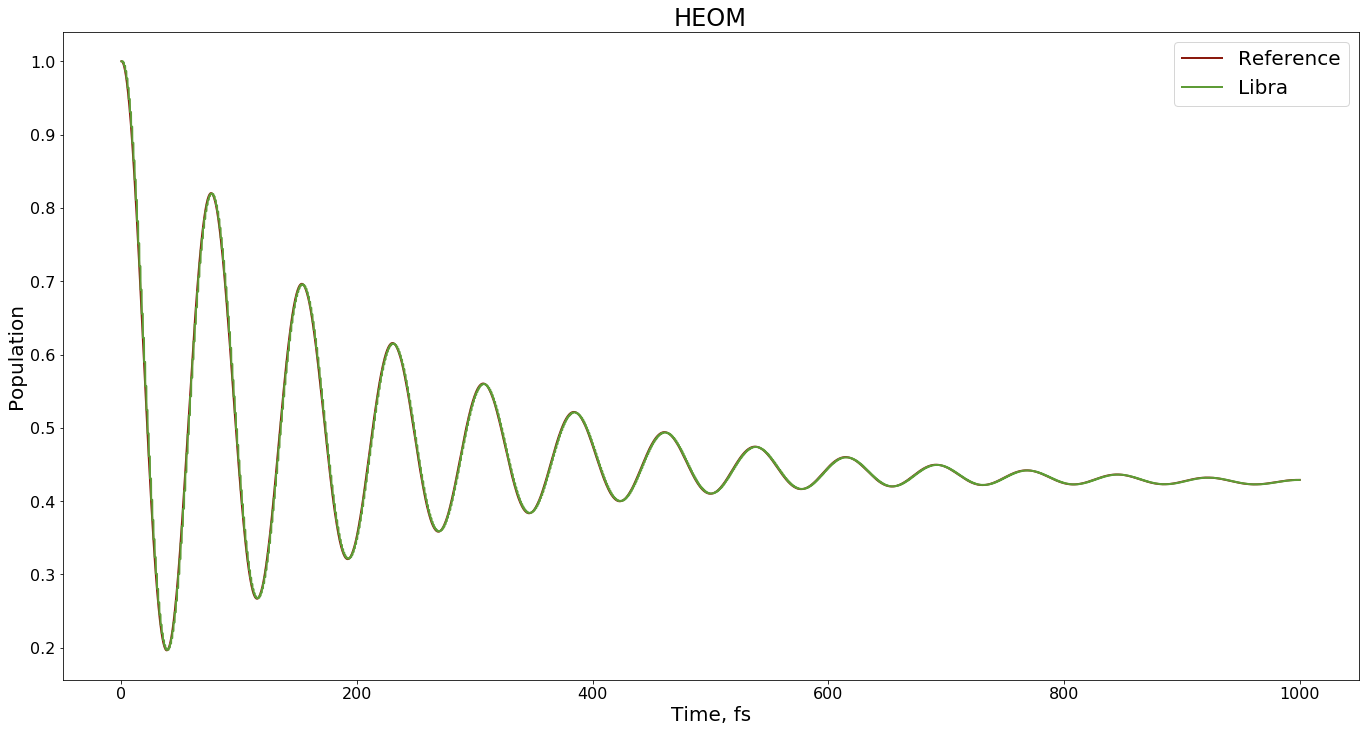

In [7]:
ref = data_read.get_data_from_file2("rho.out", [0, 1, 2] )
lib = [ None, None ]

with h5py.File(F"out/data.hdf", 'r') as f:
    lib[0] = list(f["time/data"][:] * units.au2fs)
    lib[1] = list(f["denmat/data"][:, 0,0])

    
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('HEOM')
plt.xlabel('Time, fs')
plt.ylabel('Population')
plt.plot(ref[0], ref[1], label='Reference', linewidth=2, color = colors["11"]) 
plt.plot(lib[0], lib[1], label='Libra', linewidth=2, color = colors["21"]) 
plt.legend()
plt.show()
plt.close()
